### Imports

In [346]:
%load_ext autoreload

[autoreload of src.vfm.utils.metrics_utils failed: Traceback (most recent call last):
  File "c:\Users\perer\Documents\Code\pcperera\vfm\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\perer\Documents\Code\pcperera\vfm\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\perer\.pyenv\pyenv-win\versions\3.11.9\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\perer\Documents\Code\pcperera\vfm\src\vfm\utils\metrics_utils.py", line 1, in <module>
    from vfm.model.hybrid.constants import *
ModuleNotFoundError: No module named 'vfm'
]
[aut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [347]:
%autoreload 2

In [348]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [349]:
connection = Connection()
# Get client
client = connection.get_client()

In [350]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [351]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [352]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
eps=3.417602083918777e-07
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
eps=2.9518529494535888e-05
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
eps=3.350809591825767e-08
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
eps=1.0177683450396633e-08
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
eps=1.7896994683588753e-05
W15 Record count after target preprocessing: 86
W15 Record count after p

755

In [353]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [354]:
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=527, Validation=76, Test=152


In [355]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [356]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)

TypeError: __autoreload_class__.fit.<locals>._build_residual_dataset() missing 2 required positional arguments: 'df' and 'phys'

In [ ]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.7628944091397154,
   'mae': 14.398901545735477,
   'rmse': 19.093890939023552,
   'mape (%)': 18.660137172914148,
   'mpe (%)': 12.500553591940061},
  'qw': {'r2': 0.06561047712414547,
   'mae': 1.1283975298200668,
   'rmse': 1.439380681430506,
   'mape (%)': 14380035.941443985,
   'mpe (%)': 14380003.118133642},
  'qg': {'r2': 0.6015392815755597,
   'mae': 2760.8820029524572,
   'rmse': 3494.36652085915,
   'mape (%)': 1422.715227599446,
   'mpe (%)': 1389.546122048239},
  'wgr': {'r2': -1.7214157069151392,
   'mae': 0.00011142490118752697,
   'rmse': 0.00016621916325462672,
   'mape (%)': 5031.435796838125,
   'mpe (%)': 5003.357956808601},
  'gor': {'r2': -3.1242703688089506,
   'mae': 31.856797751256078,
   'rmse': 50.145673814584576,
   'mape (%)': 1424.9599914605033,
   'mpe (%)': 1385.2936218685288}},
 'W08': {'qo': {'r2': -2.4844257427607825,
   'mae': 7.202553008614735,
   'rmse': 9.483620858842855,
   'mape (%)': 46.418200574288676,
   'mpe (%)': 46.41

In [ ]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9167704821575964,
   'mae': 9.063740472249167,
   'rmse': 11.312594749235112,
   'mape (%)': 8.742504605898288,
   'mpe (%)': -0.17633682310947582},
  'qw': {'r2': -0.9841869844605733,
   'mae': 1.4772380930492084,
   'rmse': 2.0975049176176133,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8679805685188515,
   'mae': 1360.624349285913,
   'rmse': 2011.382318537596,
   'mape (%)': 733.3166902338858,
   'mpe (%)': 712.0914366776868},
  'wgr': {'r2': -1.05047809263885,
   'mae': 0.00010327070649342032,
   'rmse': 0.00014428168813780911,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -1.5473945852164595,
   'mae': 24.162430925826527,
   'rmse': 39.4101436662556,
   'mape (%)': 736.2183917898524,
   'mpe (%)': 712.6906661058105}},
 'W08': {'qo': {'r2': -0.22100174033665465,
   'mae': 4.582778373707883,
   'rmse': 5.613926441935716,
   'mape (%)': 24.786041261248588,
   'mpe (%)': 14.058427710979782},
  'qw': {'r2': 0.7989461010648273,
 

In [ ]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9664566127295567,
   'mae': 5.37384774280152,
   'rmse': 7.1816956843239055,
   'mape (%)': 4.303573230527799,
   'mpe (%)': 3.9310759909544144},
  'qw': {'r2': -0.7426998687721522,
   'mae': 1.3424394908099313,
   'rmse': 1.965726030501084,
   'mape (%)': 1123.002269770866,
   'mpe (%)': 956.9865653934551},
  'qg': {'r2': 0.8888091523243471,
   'mae': 964.6378791653186,
   'rmse': 1845.9087120007453,
   'mape (%)': 1009.7503073212314,
   'mpe (%)': 1009.7503073212314},
  'wgr': {'r2': -0.5700133559980332,
   'mae': 9.090470407731332e-05,
   'rmse': 0.0001262511438887419,
   'mape (%)': 113.13703926753445,
   'mpe (%)': -59.253877962654336},
  'gor': {'r2': -0.09913732678486653,
   'mae': 8.852994758791377,
   'rmse': 25.887248089883414,
   'mape (%)': 1033.7714774198896,
   'mpe (%)': 1031.1533241520324}},
 'W08': {'qo': {'r2': 0.7146000096084064,
   'mae': 2.2856451169241936,
   'rmse': 2.714160672996242,
   'mape (%)': 12.453755844834776,
   'mpe (%)': 8.2103

In [ ]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

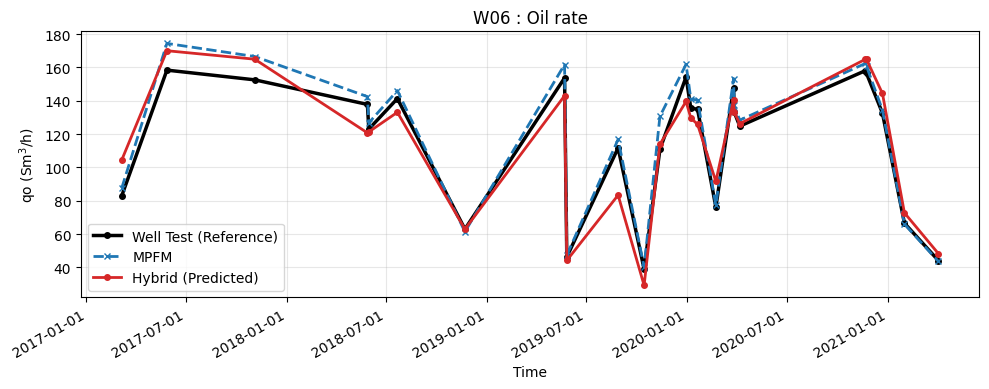

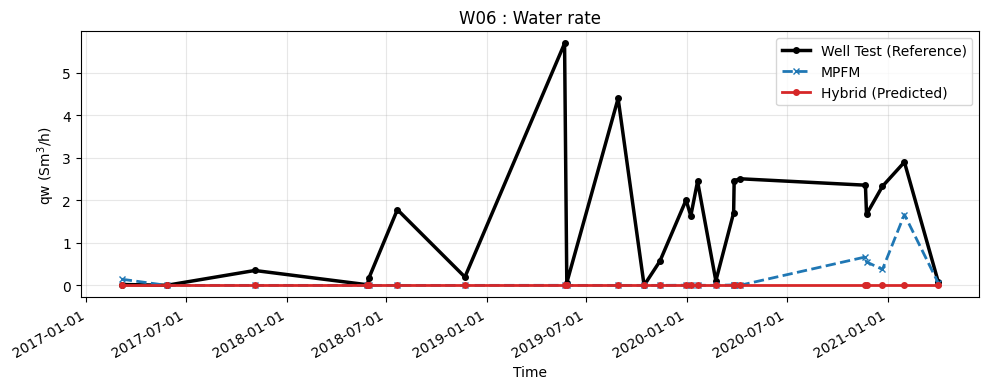

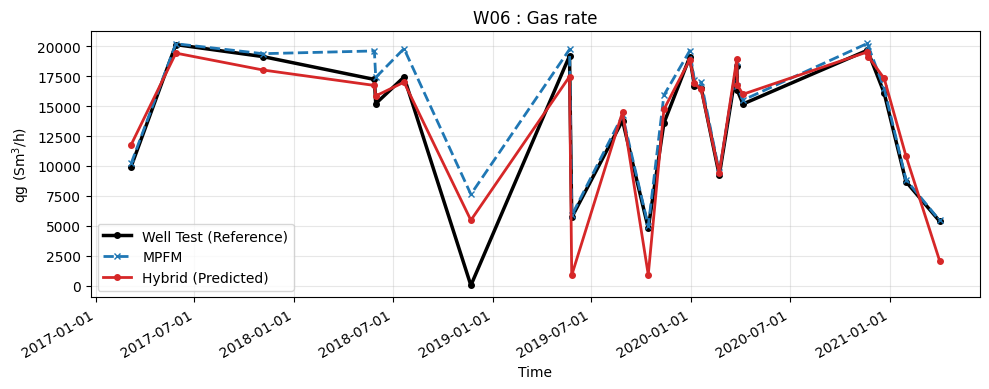

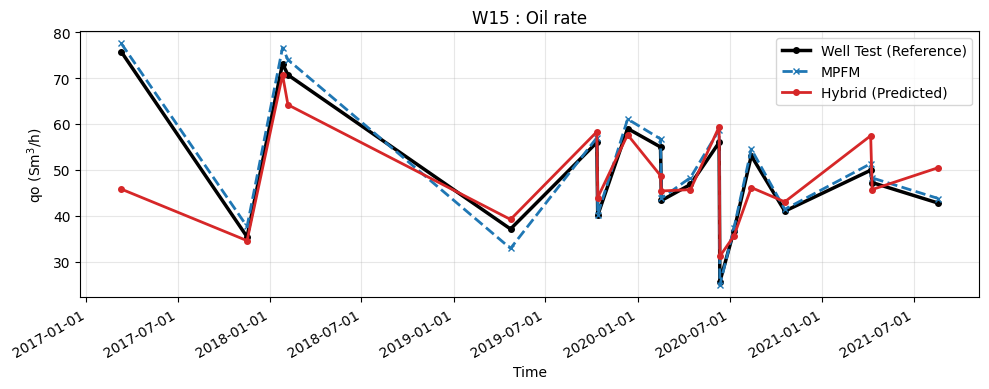

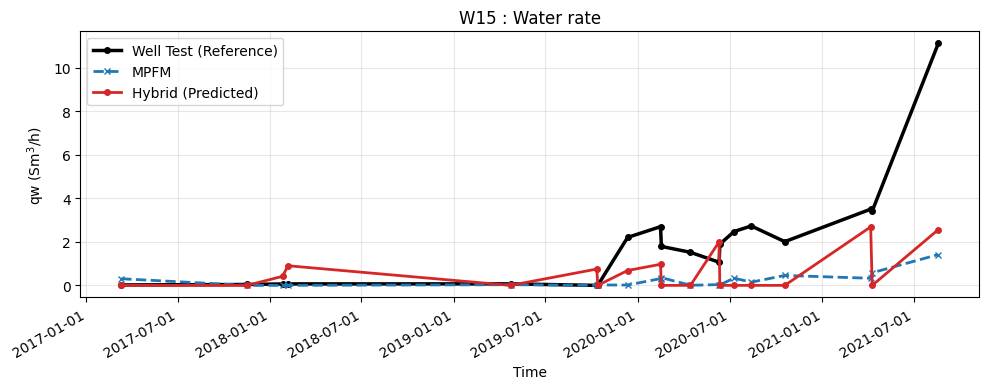

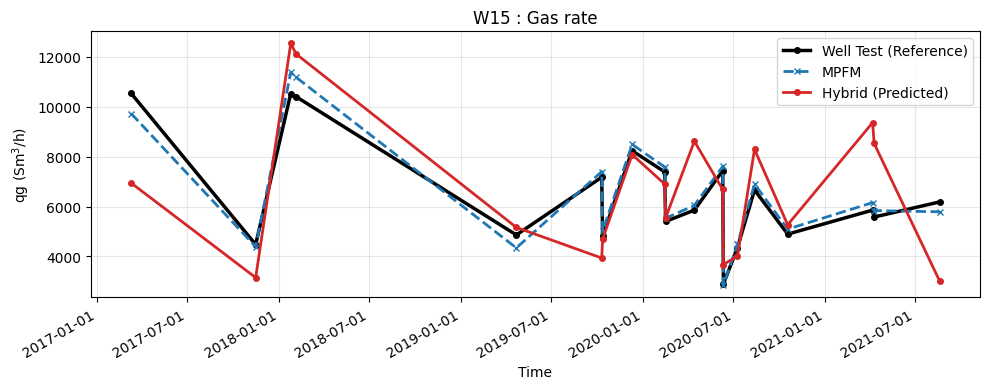

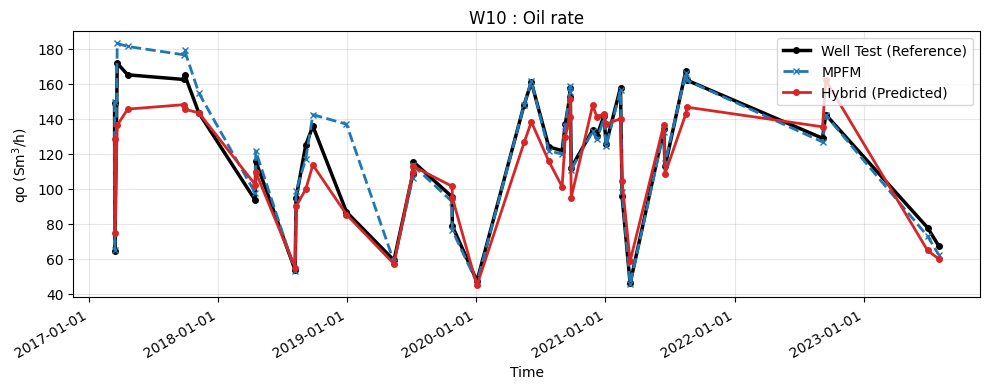

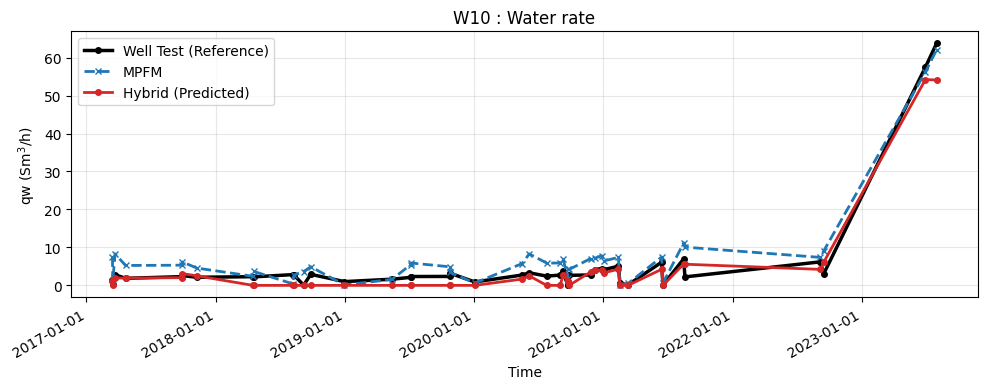

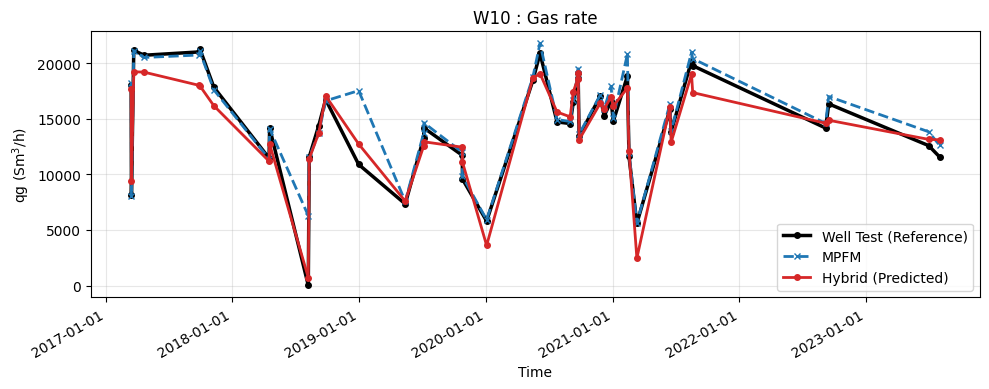

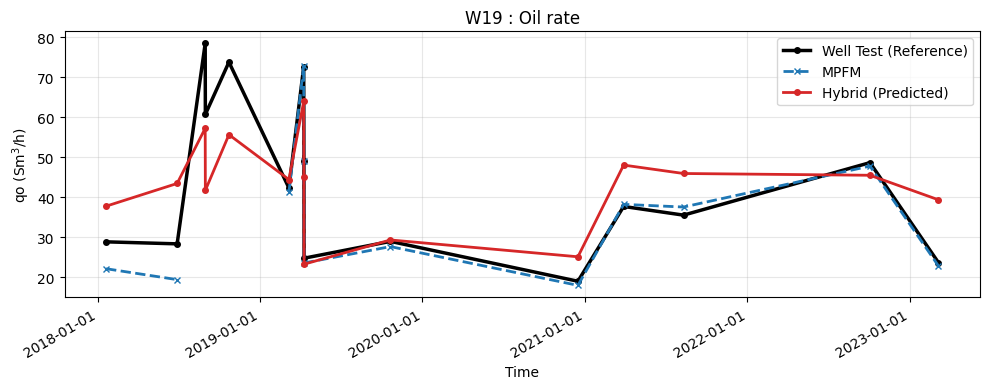

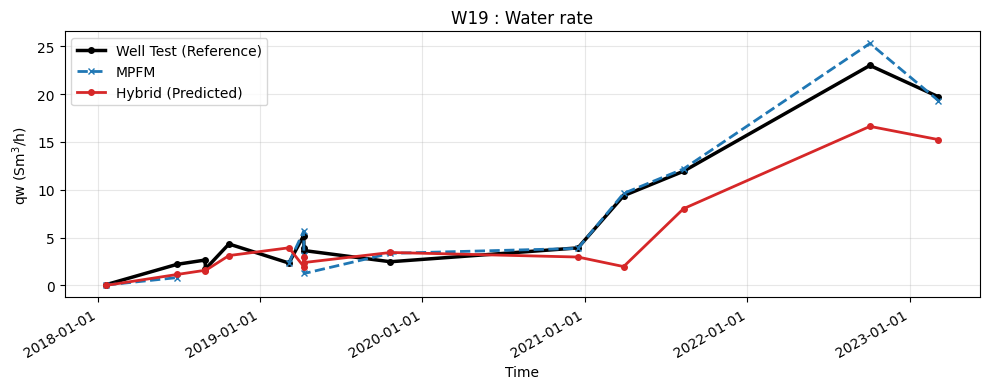

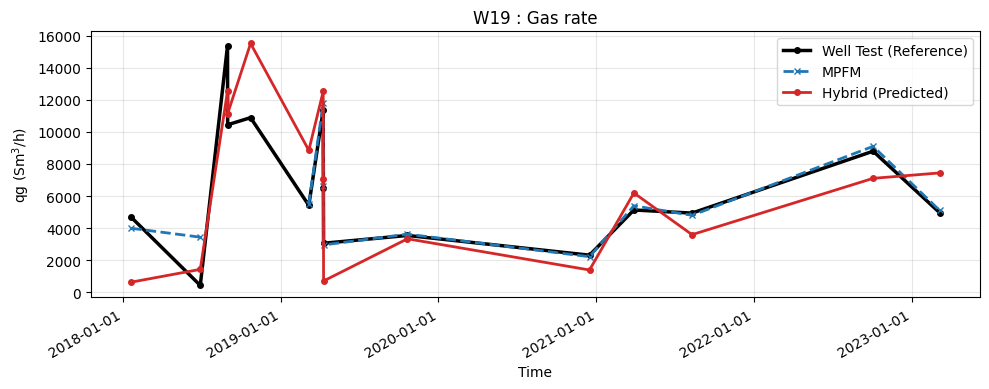

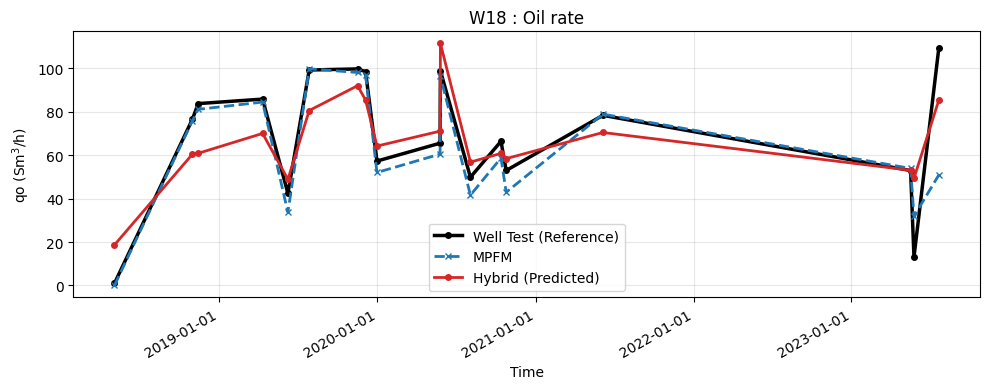

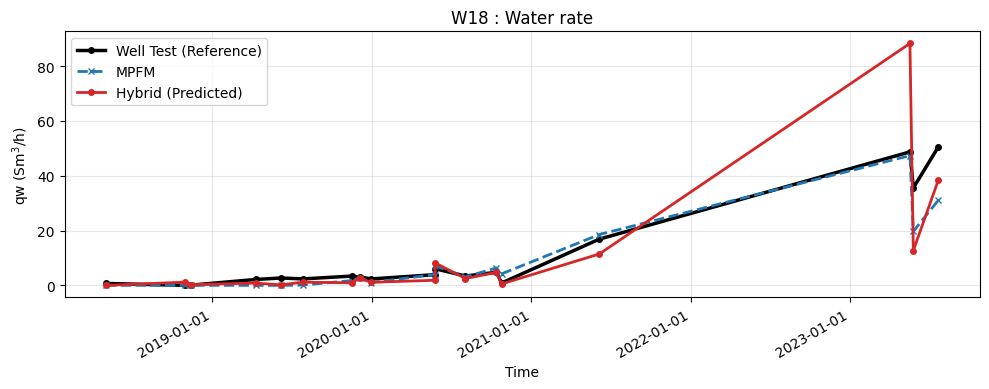

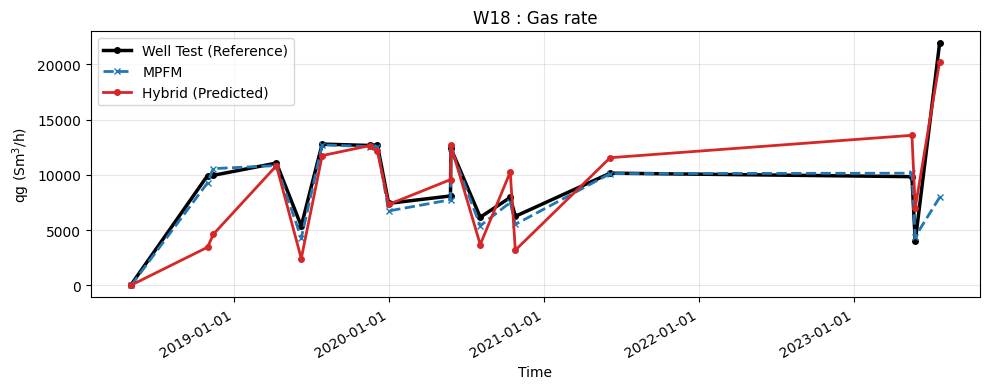

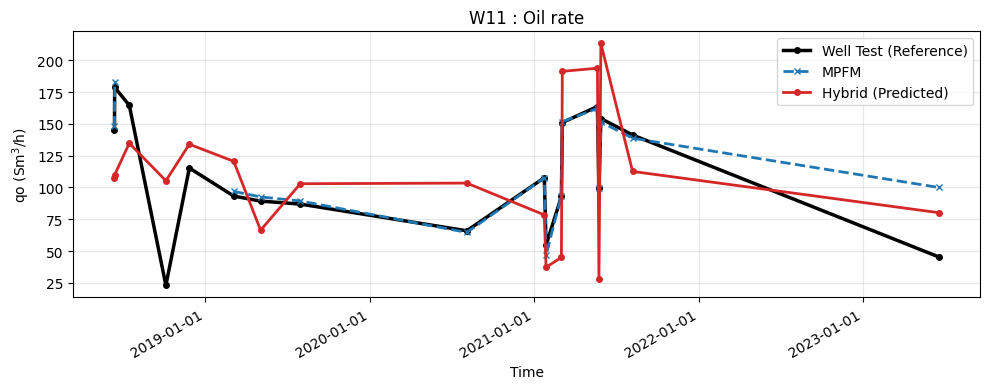

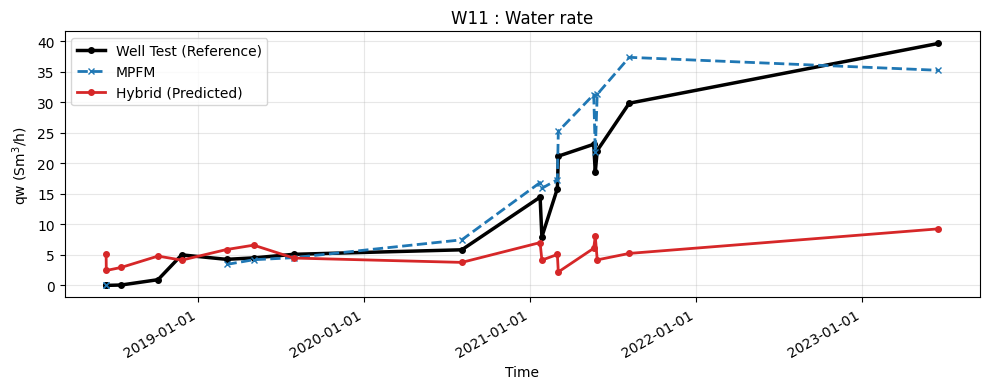

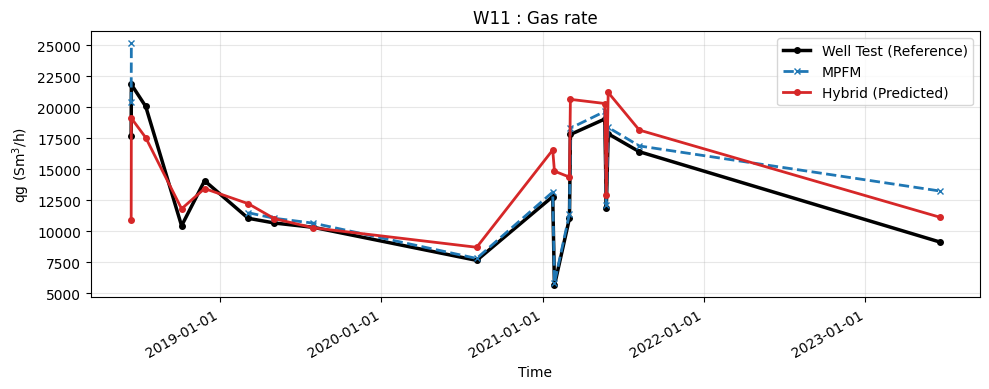

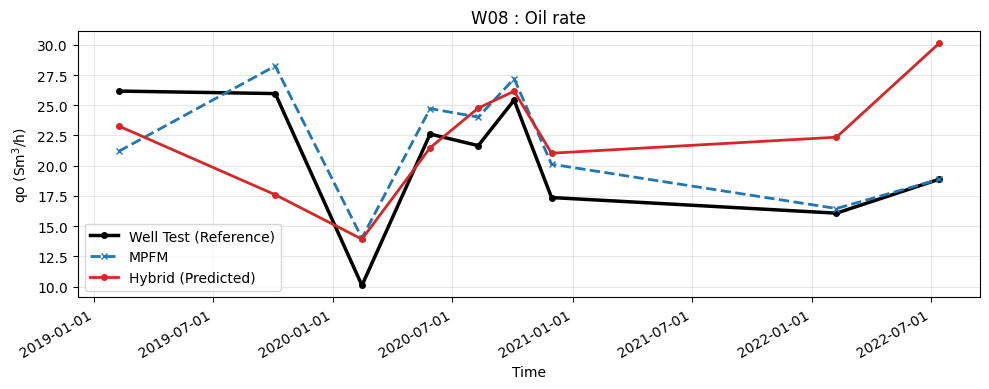

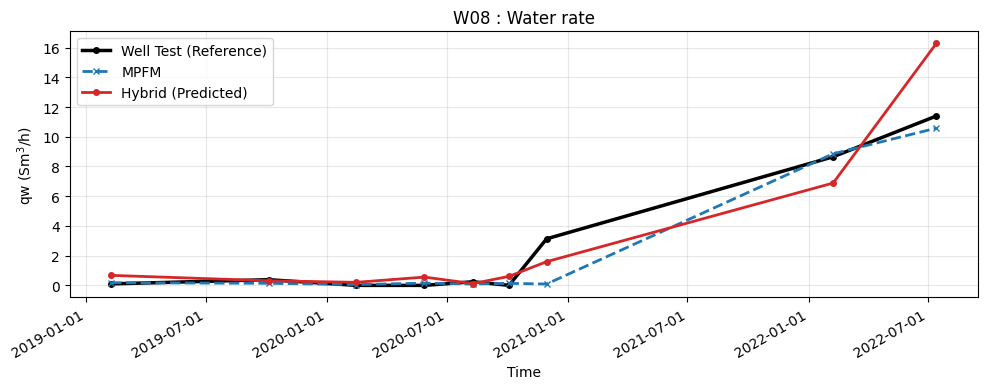

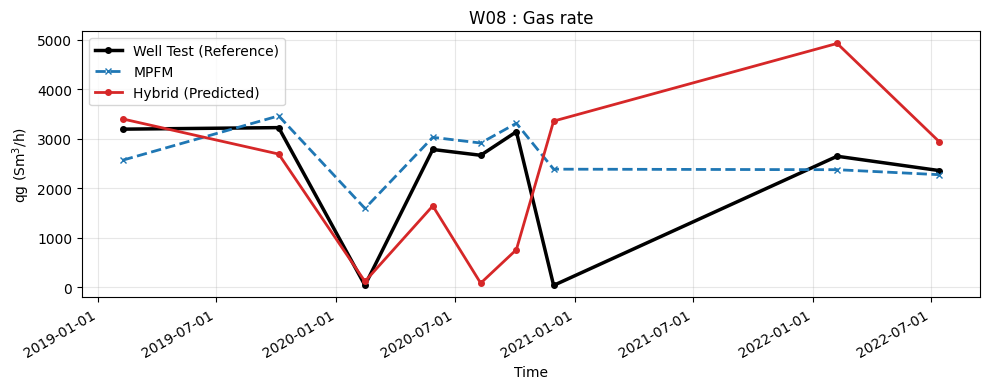

In [ ]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [ ]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=431, Val=103, Calibration=28, Test=193


In [ ]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.7163


In [ ]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [ ]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.445475508222846,
   'mae': 18.74613187002135,
   'rmse': 24.015118262058692,
   'mape (%)': 20.44390632024759,
   'mpe (%)': 9.620529883026716},
  'qw': {'r2': 0.40630788856578903,
   'mae': 3.703706196260715,
   'rmse': 6.797997268394923,
   'mape (%)': 376869573.22093105,
   'mpe (%)': 376869522.27966803},
  'qg': {'r2': 0.5172479964448102,
   'mae': 2213.3683296457452,
   'rmse': 2898.8559826283067,
   'mape (%)': 145.81220687499416,
   'mpe (%)': 118.53127782594892},
  'wgr': {'r2': 0.47494840689801554,
   'mae': 0.00029796215751579693,
   'rmse': 0.0005116177028425211,
   'mape (%)': 37509.91876002688,
   'mpe (%)': 37462.04858183802},
  'gor': {'r2': -2.851019615251563,
   'mae': 18.901608802151213,
   'rmse': 28.87963412526222,
   'mape (%)': 84.90481933793775,
   'mpe (%)': 54.927806777119855}}}

In [ ]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.5909534716141274,
   'mae': 15.941535755599627,
   'rmse': 20.625796045029695,
   'mape (%)': 14.91486206530212,
   'mpe (%)': 2.996389772946234},
  'qw': {'r2': 0.6719413840240901,
   'mae': 2.9248038990684484,
   'rmse': 5.0533115065265575,
   'mape (%)': 150925102.93312785,
   'mpe (%)': 150924983.72601956},
  'qg': {'r2': 0.19866445287304557,
   'mae': 3098.6422210810647,
   'rmse': 3734.838281139463,
   'mape (%)': 34.74749688106192,
   'mpe (%)': -1.2860803555161273},
  'wgr': {'r2': 0.6885794788387856,
   'mae': 0.00022282852762242546,
   'rmse': 0.0003940199274449227,
   'mape (%)': 13605.425096752839,
   'mpe (%)': 13478.638657107027},
  'gor': {'r2': -10.861682075237383,
   'mae': 37.62299605511076,
   'rmse': 50.684709458488854,
   'mape (%)': 39.786887934309746,
   'mpe (%)': 1.3417444893027932}}}

In [ ]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9569635375209912,
   'mae': 4.0302621733300725,
   'rmse': 6.719033986091708,
   'mape (%)': 3.342194102149555,
   'mpe (%)': 1.0301693507034981},
  'qw': {'r2': 0.8872320623164249,
   'mae': 2.533232890183563,
   'rmse': 2.976911770713921,
   'mape (%)': 355673845.1402013,
   'mpe (%)': 355673831.3504096},
  'qg': {'r2': 0.9414034834287315,
   'mae': 502.199025322619,
   'rmse': 1014.3340056036739,
   'mape (%)': 450.81157734076373,
   'mpe (%)': 449.959284046317},
  'wgr': {'r2': 0.9273631129565045,
   'mae': 0.00016403486497505227,
   'rmse': 0.00019125084908330227,
   'mape (%)': 87723.1400252045,
   'mpe (%)': 87710.06718568681},
  'gor': {'r2': -0.008805418128535969,
   'mae': 7.755096240527299,
   'rmse': 14.8583090200318,
   'mape (%)': 458.440227597175,
   'mpe (%)': 454.61031184400656}}}

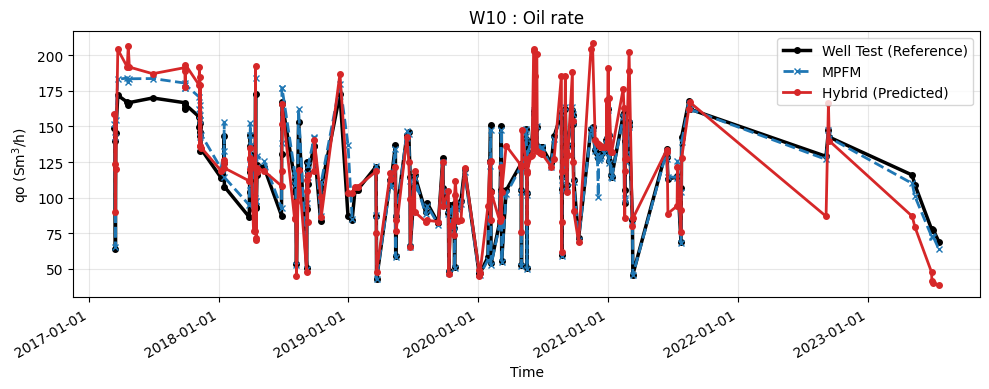

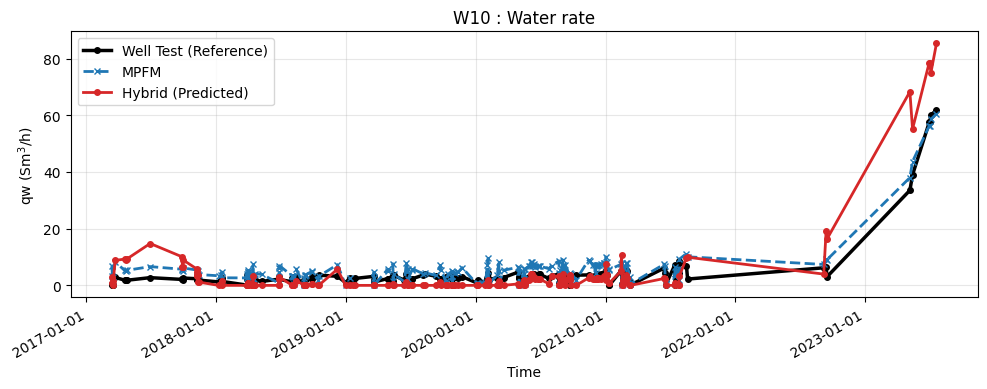

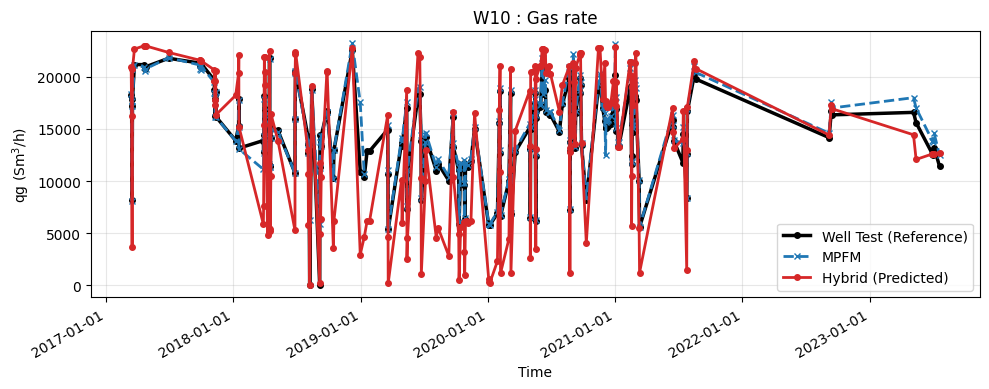

In [ ]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [ ]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [ ]:
# df_resampled.index

In [ ]:
# df_resampled.columns

In [ ]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [ ]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [ ]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [ ]:
# summarize_null(df_generated)